In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [26]:
online = "zc-emu-seed4-prognostic-30d-v2-online"
offline = "zc-emu-seed4-prognostic-30d-v2-offline"


In [ ]:

data = common.open_group(online)

In [27]:
data_off = common.open_group(offline)

In [11]:
data.isel(time=168, z=50)["cloud_water_mixing_ratio"]

<xarray.DataArray 'cloud_water_mixing_ratio' (tile: 6, y: 48, x: 48)>
dask.array<getitem, shape=(6, 48, 48), dtype=float64, chunksize=(6, 48, 48), chunktype=numpy.ndarray>
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5
    z        float64 629.6
  * y        (y) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
  * x        (x) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
    time     object 2016-07-22 03:00:00
Attributes:
    units:      kg/kg
    long_name:  cloud_water_mixing_ratio

In [29]:
from fv3viz._plot_helpers import _min_max_from_percentiles

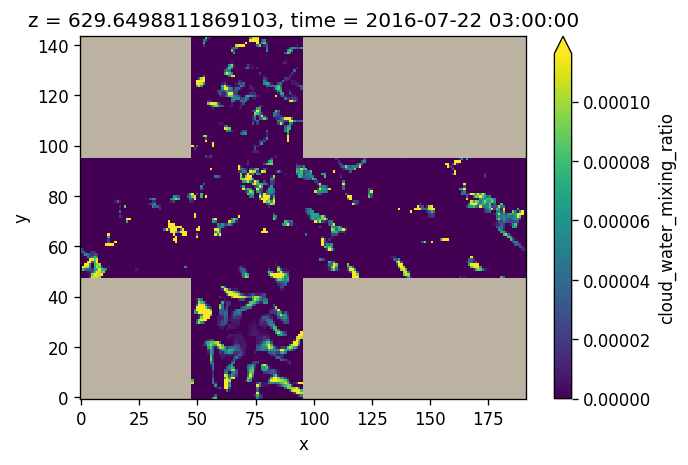

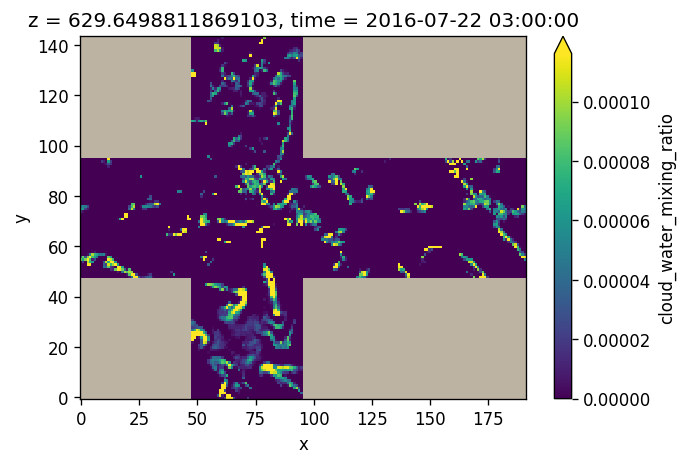

In [37]:
curr = data.isel(time=168, z=50)
curr_off = data_off.isel(time=168, z=50)
cloud_key = "cloud_water_mixing_ratio"
xmin, xmax = _min_max_from_percentiles(curr_off[cloud_key])

plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross(curr_off[cloud_key], x="x", y="y", tile="tile")
cross.plot.pcolormesh(vmin=0, vmax=xmax)
plt.show()

plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross(curr[cloud_key], x="x", y="y", tile="tile")
cross.plot.pcolormesh(vmin=0, vmax=xmax)
plt.show()

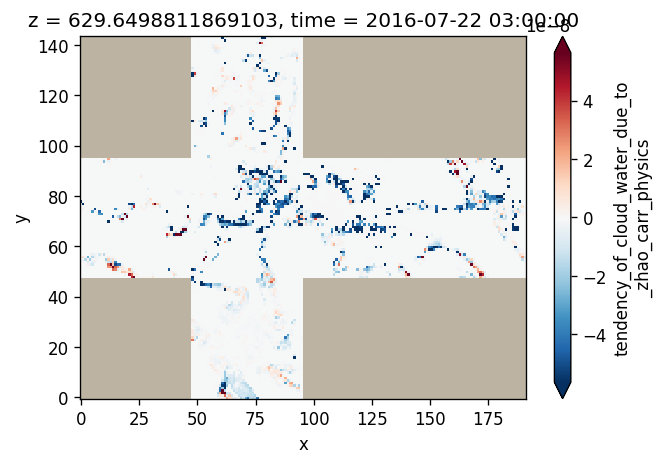

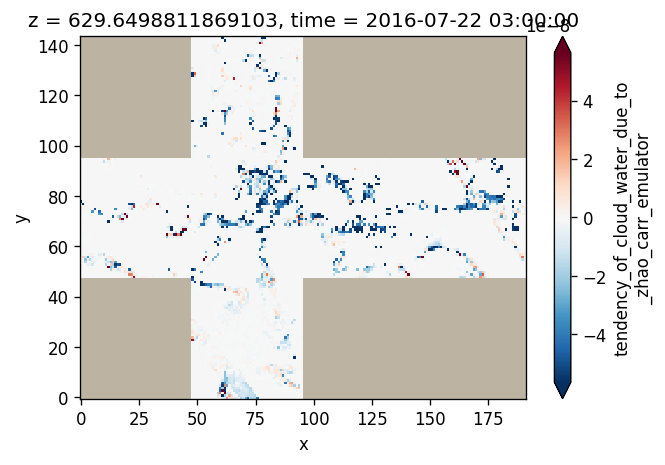

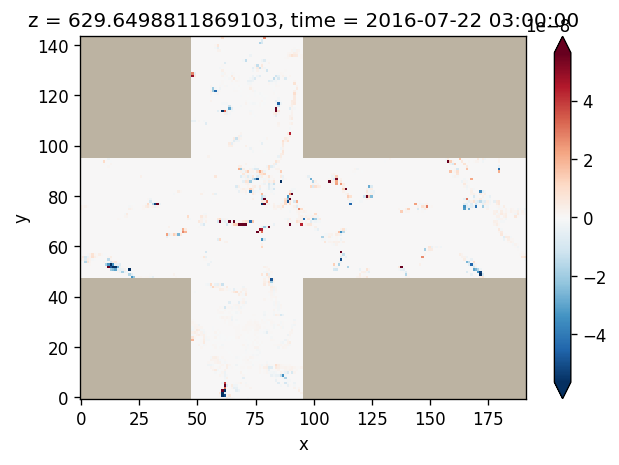

<xarray.DataArray ()>
array(1.6168982e-06, dtype=float32)
Coordinates:
    z        float64 629.6
    time     object 2016-07-22 03:00:00


In [42]:
curr = data.isel(time=168, z=50)
phys = curr["tendency_of_cloud_water_due_to_zhao_carr_physics"]
emu = curr["tendency_of_cloud_water_due_to_zhao_carr_emulator"]
xmin, xmax = _min_max_from_percentiles(phys)
lim = max(abs(xmin), abs(xmax))

plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross(phys, x="x", y="y", tile="tile")
cross.plot.pcolormesh(vmin=-lim, vmax=lim, cmap="RdBu_r")
plt.show()

plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross(emu, x="x", y="y", tile="tile")
cross.plot.pcolormesh(vmin=-lim, vmax=lim, cmap="RdBu_r")
plt.show()

plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross(emu - phys, x="x", y="y", tile="tile")
cross.plot.pcolormesh(vmin=-lim, vmax=lim, cmap="RdBu_r")
plt.show()

print(abs(emu - phys).max().compute())

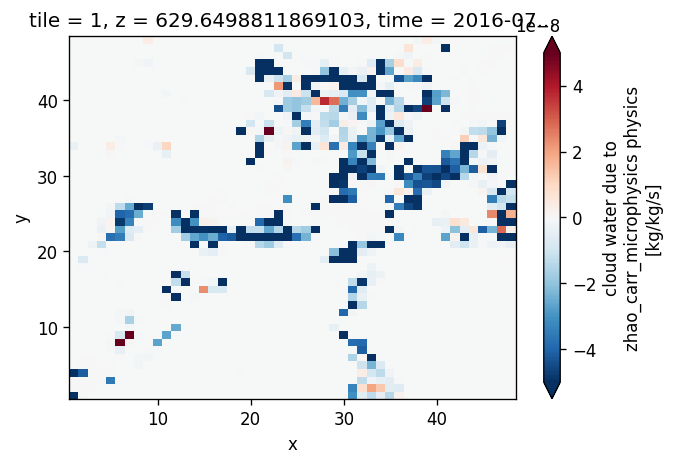

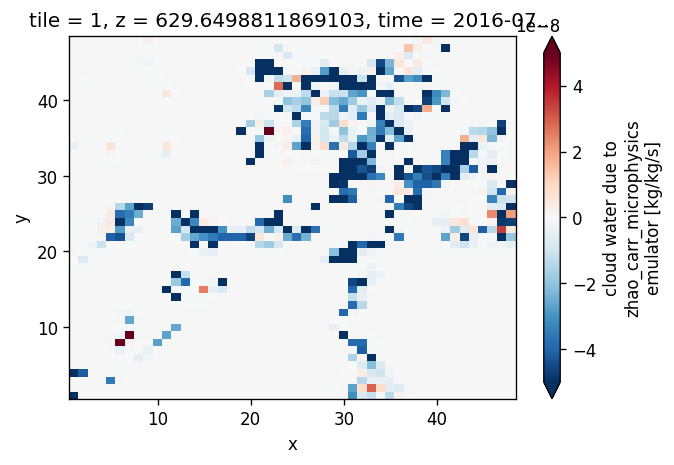

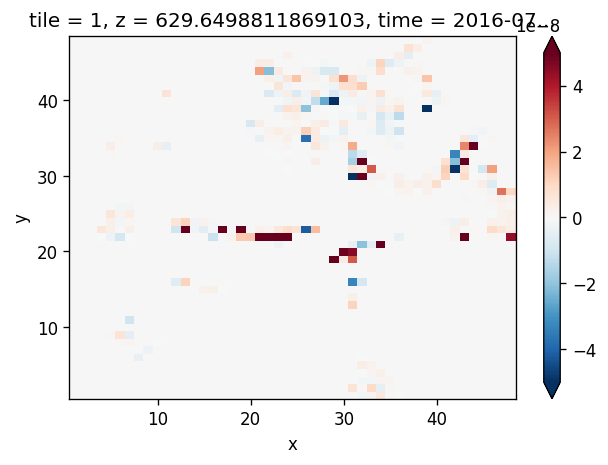

<xarray.DataArray ()>
array(1.6168982e-06, dtype=float32)
Coordinates:
    tile     int64 1
    z        float64 629.6
    time     object 2016-07-22 03:00:00


In [106]:
curr = data.isel(time=168, z=50, tile=1)
phys = curr["tendency_of_cloud_water_due_to_zhao_carr_physics"]
emu = curr["tendency_of_cloud_water_due_to_zhao_carr_emulator"]
lim = 5e-8

plt.figure(dpi=120)
phys.plot.pcolormesh(vmin=-lim, vmax=lim, cmap="RdBu_r")
plt.show()

plt.figure(dpi=120)
emu.plot.pcolormesh(vmin=-lim, vmax=lim, cmap="RdBu_r")
plt.show()

plt.figure(dpi=120)
((emu-phys)).plot.pcolormesh(vmin=-lim, vmax=lim, cmap="RdBu_r")
plt.show()

print(abs(emu - phys).max().compute())

In [45]:
def mse(x: xr.DataArray, y, area, dims=None):
    if dims is None:
        dims = set(area.dims)
    return vcm.weighted_average((x - y) ** 2, area, dims)


def skill_improvement(truth, pred, area):
    return 1 - mse(truth, pred, area) / mse(truth, 0, area)


def skill_improvement_column(truth, pred, area):
    return 1 - mse(truth, pred, area).mean() / mse(truth, 0, area).mean()

In [47]:
skill_improvement(phys, emu, curr["area"]).compute()

<xarray.DataArray ()>
array(0.26944464, dtype=float32)
Coordinates:
    z        float64 629.6
    time     object 2016-07-22 03:00:00

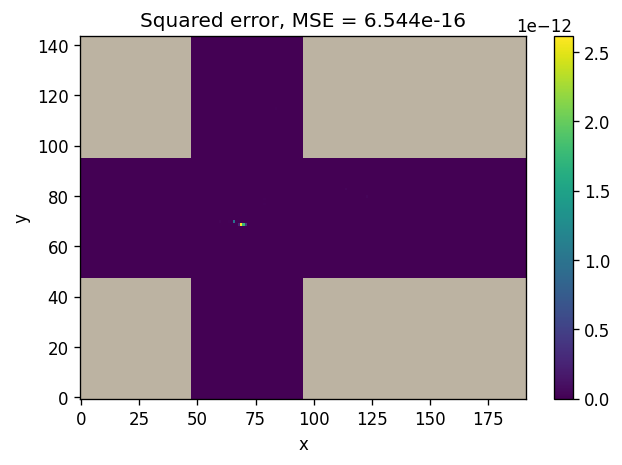

In [61]:
plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross((emu-phys)**2, x="x", y="y", tile="tile")
cross.plot.pcolormesh(cmap="viridis")
plt.title(f"Squared error, MSE = {mse(phys, emu, curr.area).compute().values:1.3e}")
plt.show()

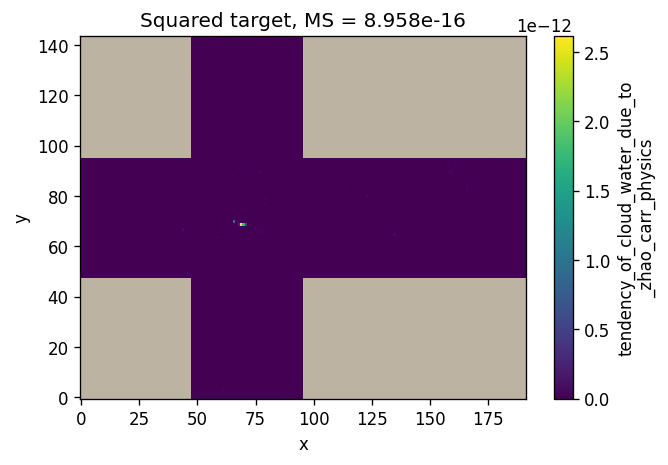

In [62]:
plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross((phys)**2, x="x", y="y", tile="tile")
cross.plot.pcolormesh(cmap="viridis")
plt.title(f"Squared target, MS = {mse(phys, 0, curr.area).compute().values:1.3e}")
plt.show()

In [80]:
sq_err = (emu-phys)**2
skill_improvement(phys.where(sq_err < 1e-13), emu.where(sq_err < 1e-13), curr.area).compute()

<xarray.DataArray ()>
array(0.8809783, dtype=float32)
Coordinates:
    z        float64 629.6
    time     object 2016-07-22 03:00:00

In [74]:
(sq_err > 1e-14).sum().compute()

<xarray.DataArray ()>
array(13)
Coordinates:
    z        float64 629.6
    time     object 2016-07-22 03:00:00

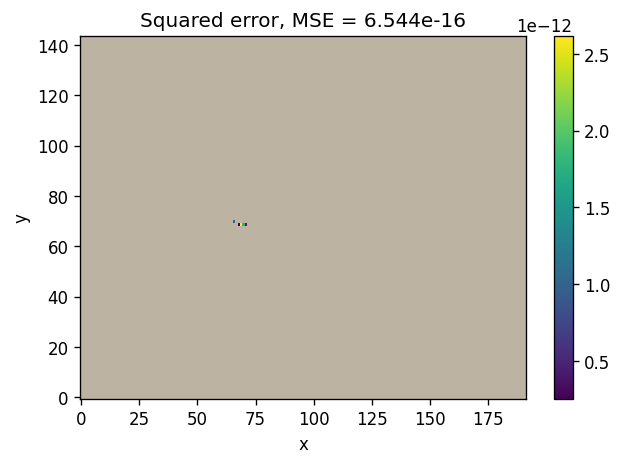

In [79]:
plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross(((emu-phys)**2).where(sq_err > 1e-13), x="x", y="y", tile="tile")
cross.plot.pcolormesh(cmap="viridis")
plt.title(f"Squared error, MSE = {mse(phys, emu, curr.area).compute().values:1.3e}")
plt.show()

Go from 26% to 88% skill by dropping 5 points in the tropics.

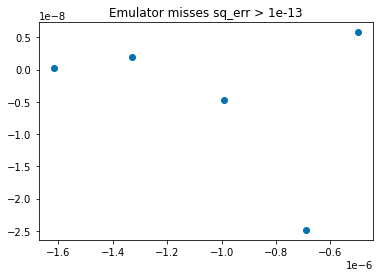

In [107]:
plt.scatter(phys.where(sq_err > 1e-13), emu.where(sq_err > 1e-13).values)
# lims=(-1.8e-6,1.8e-6)
# plt.ylim(lims)
# plt.xlim(lims)
plt.title("Emulator misses sq_err > 1e-13")
plt.show()

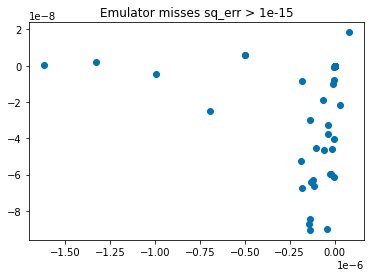

In [108]:
plt.scatter(phys.where(sq_err > 1e-15), emu.where(sq_err > 1e-15).values)
plt.title("Emulator misses sq_err > 1e-15")
plt.show()

Big misses on removal of cloud, so precipitation should be under-predicted

The emulator is not as sensitive, produces smaller moves, generally

In [66]:
pr_phys = curr["surface_precipitation_due_to_zhao_carr_physics"]
pr_emu = curr["surface_precipitation_due_to_zhao_carr_emulator"]

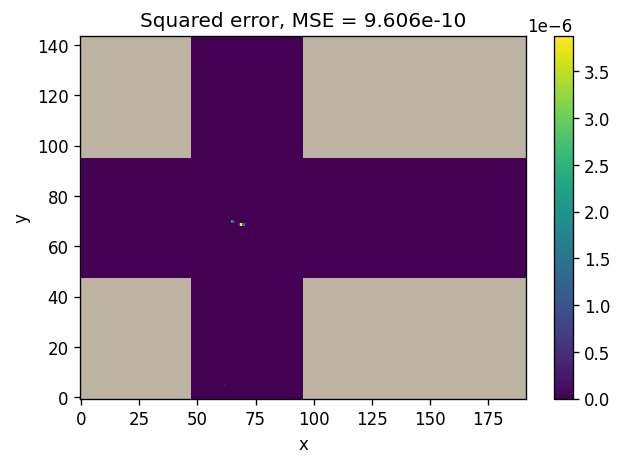

In [81]:
plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross((pr_emu-pr_phys)**2, x="x", y="y", tile="tile")
cross.plot.pcolormesh(cmap="viridis")
plt.title(f"Squared error, MSE = {mse(pr_phys, pr_emu, curr.area).compute().values:1.3e}")
plt.show()

In [82]:
skill_improvement(pr_phys.where(sq_err < 1e-13), pr_emu.where(sq_err < 1e-13), curr.area).compute()

<xarray.DataArray ()>
array(0.9076537, dtype=float32)
Coordinates:
    z        float64 629.6
    time     object 2016-07-22 03:00:00

In [83]:
skill_improvement(pr_phys, pr_emu, curr.area).compute()

<xarray.DataArray ()>
array(0.7553341, dtype=float32)
Coordinates:
    z        float64 629.6
    time     object 2016-07-22 03:00:00

Precip goes from 76 -> 91 by dropping those five points in the tropics

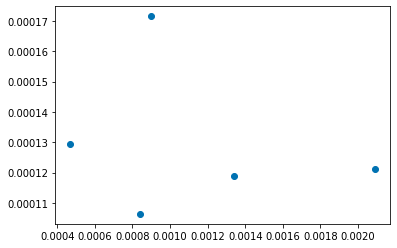

In [93]:
plt.scatter(pr_phys.where(sq_err > 1e-13), pr_emu.where(sq_err > 1e-13).values)
plt.show()

Large precip underprediction at those same points.